# Test Wave Solver

In [48]:
using PyPlot
using PyCall
using LinearAlgebra
ot = pyimport("ot")
include("acoustic_solver.jl")
include("sinkhorn_1d.jl")

function sinkhorn_signal_2d(f, g, M; lambda=100, numItermax = 1000, stopThr = 1e-6, verbose=false)
    Nx, Ny = size(f)
    N = Nx * Ny
    f = f[:]
    g = g[:]
    # normalization
    fp = zeros(N)
    fn = zeros(N)
    fp[f .>= 0] = f[f .>= 0]
    fn[f .< 0] = f[f .< 0]
    fn = abs.(fn)

    gp = zeros(N)
    gn = zeros(N)
    gp[g .>= 0] = g[g .>= 0]
    gn[g .< 0] = g[g .< 0]
    gn = abs.(gn)

    fp = fp ./ norm(fp,1)
    fn = fn ./ norm(fn,1)
    gp = gp ./ norm(gp,1)
    gn = gn ./ norm(gn,1);
    
    Tp, ap, dp = sinkhorn_basic(fp, gp, M; lambda=lambda, numItermax=numItermax, stopThr=stopThr, verbose=verbose)
    Tn, an, dn = sinkhorn_basic(fn, gn, M; lambda=lambda, numItermax=numItermax, stopThr=stopThr, verbose=verbose)
    
    T = Tp + Tn;
    a = ap - an;
    d = dp + dn;
    return T, a, d
end

sinkhorn_signal_2d (generic function with 1 method)

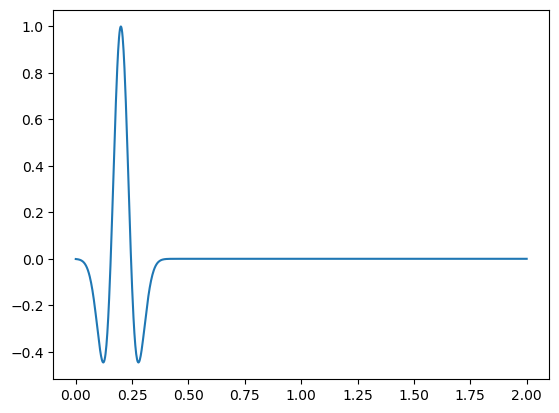

In [2]:
Nx = 101;
Ny = 101;
h = 0.01;

Fs = 500;
dt = 1/Fs
Nt = 1001;
t = range(0, length=Nt, step=dt)

source = source_ricker(5, 0.2, t)
plot(t,source)
source_position = [3,51]

receiver_position = zeros(11,2)
for i = 1:11
    receiver_position[i,:] = [1,(i-1)*10+1]
end

In [3]:
c1 = ones(Nx, Ny)
rho1 = ones(Nx, Ny)
c1[30:50,20:59] .= 1.1;

c2 = ones(Nx, Ny)
rho2 = ones(Nx, Ny)
c2[50:end,:] .= 1.1;

In [4]:
data1, p1 = acoustic_eq_solver(c1, rho1, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=20, pml_coef=50);
data2, p2 = acoustic_eq_solver(c2, rho2, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=20, pml_coef=50);

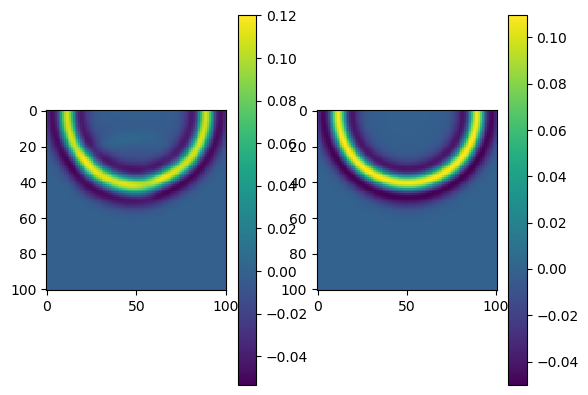

PyObject <matplotlib.colorbar.Colorbar object at 0x103e1d1f28>

In [5]:
figure; subplot(121); imshow(p1[:,:,300]); colorbar()
subplot(122);imshow(p2[:,:,300]); colorbar()

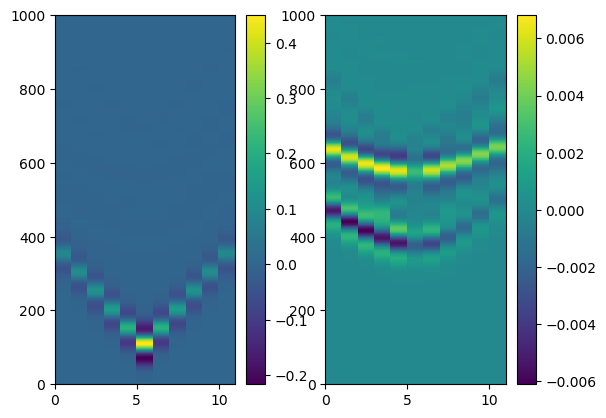

PyObject <matplotlib.colorbar.Colorbar object at 0x1044ebf780>

In [6]:
figure; subplot(121); pcolor(data1); colorbar(); 
subplot(122); pcolor(data2-data1); colorbar()

## Trace by trace gradient

In [69]:
function sinkhorn_signal(r, c, M, lambda)
    
    N = length(r)
    
    # normalization
    cp = zeros(N)
    cn = zeros(N)
    cp[c .>= 0] = c[c .>= 0]
    cn[c .< 0] = c[c .< 0]
    cn = abs.(cn)
    
    rp = zeros(N)
    rn = zeros(N)
    rp[r .>= 0] = r[r .>= 0]
    rn[r .< 0] = r[r .< 0]
    rn = abs.(rn)
    
    # for robustness
    cp .+= 0.01*maximum(cp)
    cn .+= 0.01*maximum(cn)
    rp .+= 0.01*maximum(cp)
    rn .+= 0.01*maximum(cn)

#     normalization
    cp = cp ./ norm(cp,1)
    cn = cn ./ norm(cn,1)
    rp = rp ./ norm(rp,1)
    rn = rn ./ norm(rn,1)

#     compute sinkhorn
    Gp = ot.sinkhorn(rp, cp, M, lambda, verbose=false)
    Gn = ot.sinkhorn(rn, cn, M, lambda, verbose=false)

#     compute distence
    
    d = sum(Gp.*M) + sum(Gn.*M)
    
    return Gp, Gn, d
end

sinkhorn_signal (generic function with 1 method)

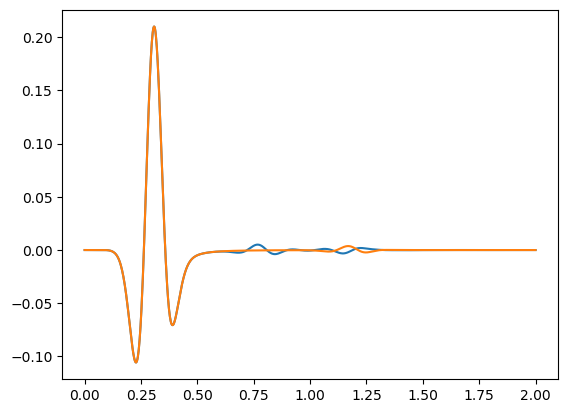

2-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x104e61fb38>
 PyObject <matplotlib.lines.Line2D object at 0x104e61fc88>

In [52]:
f = data1[:,5]
g = data2[:,5]

plot(t,f,t,g)

In [53]:
# Build loss matrix
M = zeros(Nt,Nt)
for i = 1:Nt
    for j = 1:Nt
        M[i,j] = (t[i] - t[j])^2
    end
end
# imshow(M)

In [66]:
T, a, d = sinkhorn_signal_1D(f, g, M; lambda=500, numItermax = 10000, stopThr = 1e-6, verbose=true);

Iteration number: 10001
Error: 2.4357547944529952e25
Iteration number: 10001
Error: 8797.210108124185


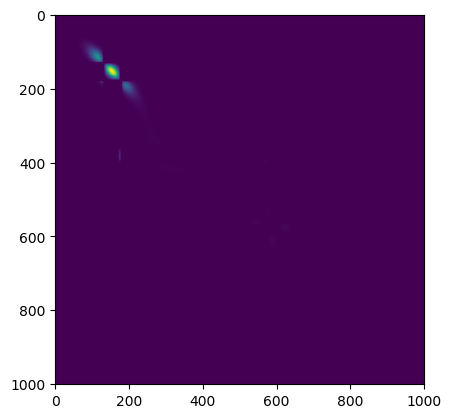

PyObject <matplotlib.image.AxesImage object at 0x104d6c1208>

In [67]:
figure;
imshow(T)

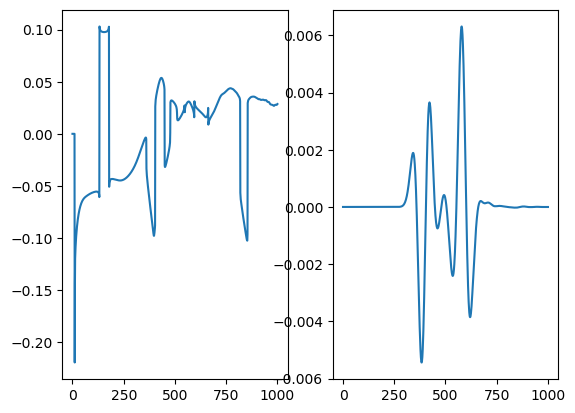

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1051fcba90>

In [68]:
figure;
subplot(121); plot(a)
subplot(122); plot(g-f)

## Trace by Trace

In [70]:
grad = zeros(Nt,11)
for i = 1:11
    f = data1[:,i]
    g = data2[:,i]
    
    T, grad[:,i], d = sinkhorn_signal_1D(f, g, M; lambda=100, numItermax = 1000, stopThr = 1e-6, verbose=true);
end

Iteration number: 94
Error: 9.184564177732846e-7
Iteration number: 137
Error: 9.887490724124988e-7
Iteration number: 106
Error: 9.909908036118262e-7
Iteration number: 145
Error: 9.783614299334985e-7
Iteration number: 480
Error: 9.99831507641729e-7
Iteration number: 338
Error: 9.66800031279636e-7
Iteration number: 994
Error: 0.0
Iteration number: 1001
Error: 1.4329135652815317e-5
Iteration number: 537
Error: 9.663230228645295e-7
Iteration number: 486
Error: 9.973505396410007e-7
Iteration number: 369
Error: 9.776871596648983e-7
Iteration number: 268
Error: 9.896768510489069e-7
Iteration number: 287
Error: 9.412567462920395e-7
Iteration number: 276
Error: 9.791361987241032e-7
Iteration number: 422
Error: 9.676205768659003e-7
Iteration number: 236
Error: 9.884446909517523e-7
Iteration number: 128
Error: 9.004426576369759e-7
Iteration number: 182
Error: 9.815415071128838e-7
Iteration number: 75
Error: 8.789262082577721e-7
Iteration number: 171
Error: 9.970935390935994e-7
Iteration number: 5

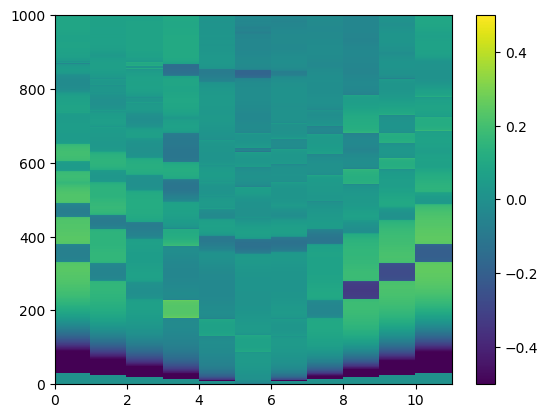

In [74]:
pcolor(grad); colorbar(); clim([-0.5,0.5])

## 2D signal

In [43]:
Nx = Nt;
Ny = 11;

h = 0.02;
x = range(0, step=h, length=Nx)
y = range(0, step=h, length=Ny)'

X = zeros(Nx, Ny)
Y = zeros(Nx, Ny)
for i = 1:Ny
    X[:,i] = x
end
for j = 1:Nx
    Y[j,:] = y
end

XX = X[:]
YY = Y[:]
M = zeros(Nx*Ny, Nx*Ny)
for i = 1:Nx*Ny
    for j = 1:Nx*Ny
        M[i,j] = (XX[i] - XX[j]) ^ 2 + (YY[i] - YY[j])^2
    end
end

In [44]:
T, a, d = sinkhorn_signal_2d(data1, data2, M; lambda=100, numItermax = 1000, stopThr = 1e-6, verbose=true);

Iteration number: 1001
Error: 1.1189686713085463e239
Iteration number: 1001
Error: 3.060723647792744e46


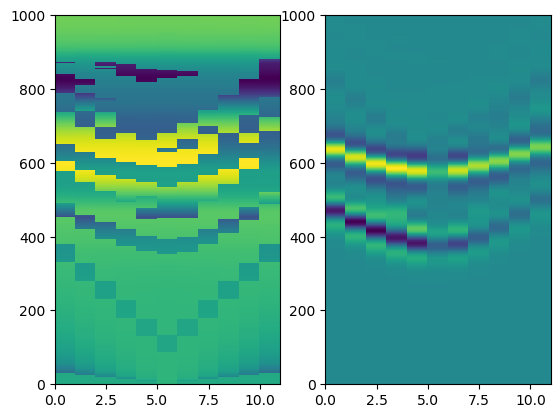

PyObject <matplotlib.collections.PolyCollection object at 0x104dd47eb8>

In [47]:
figure;
a0 = reshape(a, Nt, 11)
subplot(121); pcolor(a0)
subplot(122); pcolor(data2- data1)